In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import probplot
import seaborn as sns
import folium
from folium.plugins import HeatMap
plt.style.use('seaborn')
from tqdm.notebook import tqdm
import datetime as dt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from IPython.display import clear_output

In [2]:
# Import data
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

### Features and Trends
In this section, some features have been generated and their behavior with price has been observed. This will help us to choose good features and generate new ones with these chosen features.

In [3]:
train

,id,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,770,10000,1.0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17205,2997800021,2015-02-19,475000.0,3,1310,1294,2.0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
17206,263000018,2014-05-21,360000.0,3,1530,1131,3.0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
17207,1523300141,2014-06-23,402101.0,2,1020,1350,2.0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
17208,291310100,2015-01-16,400000.0,3,1600,2388,2.0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [4]:
test

,id,date,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1321400060,2014-06-27,3,1715,6819,2.0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
1,3793500160,2015-03-12,3,1890,6560,2.0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
2,9297300055,2015-01-24,4,2950,5000,2.0,0,3,9,1980,970,1979,0,98126,47.5714,-122.375,2140,4000
3,16000397,2014-12-05,2,1200,9850,1.0,0,4,7,1200,0,1921,0,98002,47.3089,-122.210,1060,5095
4,6300500875,2014-05-14,4,1620,4980,1.0,0,4,7,860,760,1947,0,98133,47.7025,-122.341,1400,4980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205,1931300090,2014-05-07,3,1680,1570,3.0,0,3,8,1680,0,2014,0,98103,47.6572,-122.346,1640,4800
4206,3881900317,2015-01-23,4,1900,2631,2.0,0,3,9,1250,650,2014,0,98144,47.5869,-122.311,1710,4502
4207,7853420110,2014-10-03,3,2780,6000,2.0,0,3,9,2780,0,2013,0,98065,47.5184,-121.886,2850,6000
4208,2767600688,2014-11-13,2,1210,1278,2.0,0,3,8,1020,190,2007,0,98117,47.6756,-122.375,1210,1118


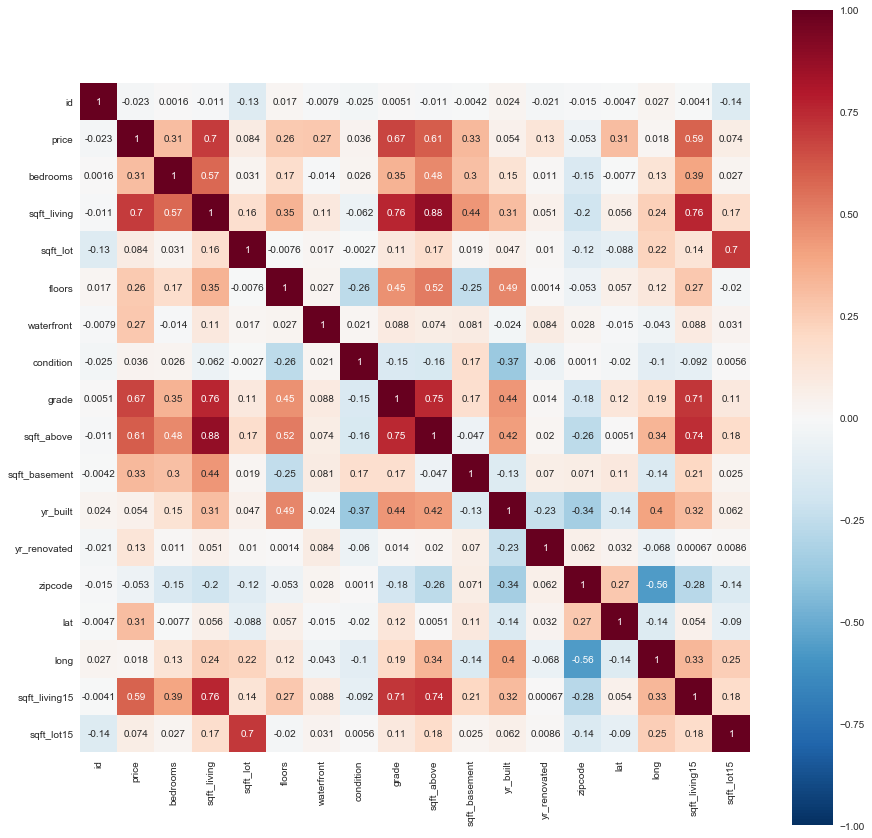

In [5]:
# Correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr(), square=True, annot=True, cmap='RdBu_r', vmin=-1.0, vmax=1.0)
plt.show()

Living area, number of bedrooms, grade, area above and living area in 2015 strongly affect the price. Other weak indicators include number of bedrooms, number of floors, waterfront, basement area and location (latitude). Surprisingly condition doesn't affect the price much. Perhaps because condition will improve when people live there, and degrade when the house is abandoned so tenants don't care about the current state of the house. Condition is a tricky feature to understand. It is negatively correlated with grade, and living area. It doesn't seem to affect the price. Larger values of yr_built (newer houses) have lower conditions. Perhaps it's not a good feature

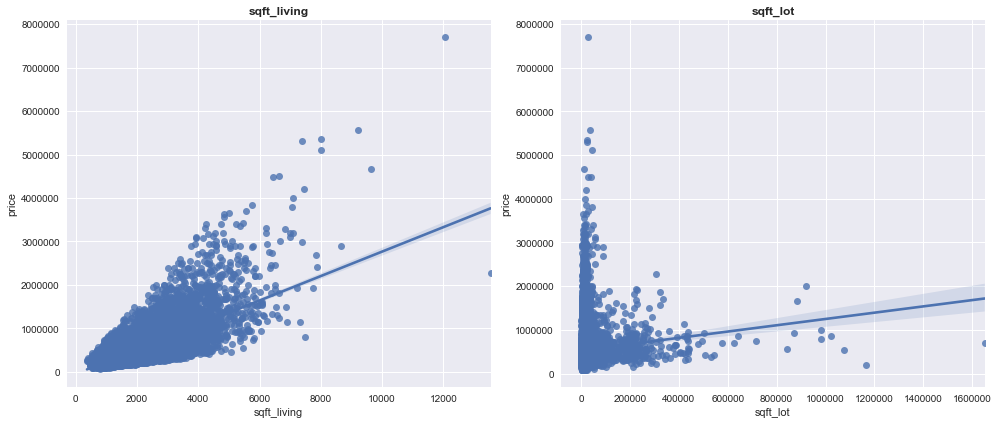

In [6]:
# Lot and living areas
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.regplot(x='sqft_living', y='price', data=train)
ax1.set_title('sqft_living', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.regplot(x='sqft_lot', y='price', data=train)
ax2.set_title('sqft_lot', fontweight='bold')
plt.tight_layout()
plt.show()

Living area has a clear rising trend with price, with few outliers. Interestingly all house prices are enveloped by a region between two lines. Could there be a restriction on the price for a house (like an MRP)? Either way, this tells us that simple linear regression won't do, since many houses with the same area have varying prices. Lot area doesn't have strong trend with price. Another thing to notice is the amount of uncertainty (standard error) for these regressions, which is higher for lot area (and quite small for living area).

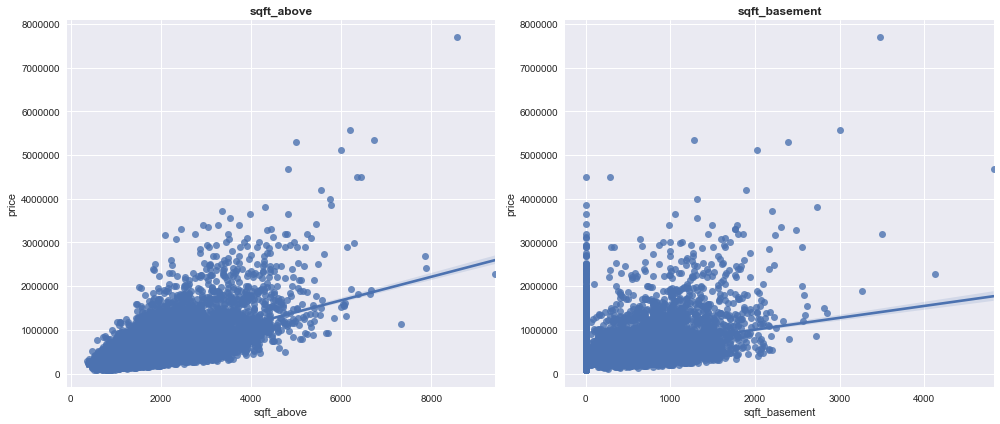

In [7]:
# Above and basement areas
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.regplot(x='sqft_above', y='price', data=train)
ax1.set_title('sqft_above', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.regplot(x='sqft_basement', y='price', data=train)
ax2.set_title('sqft_basement', fontweight='bold')
plt.tight_layout()
plt.show()

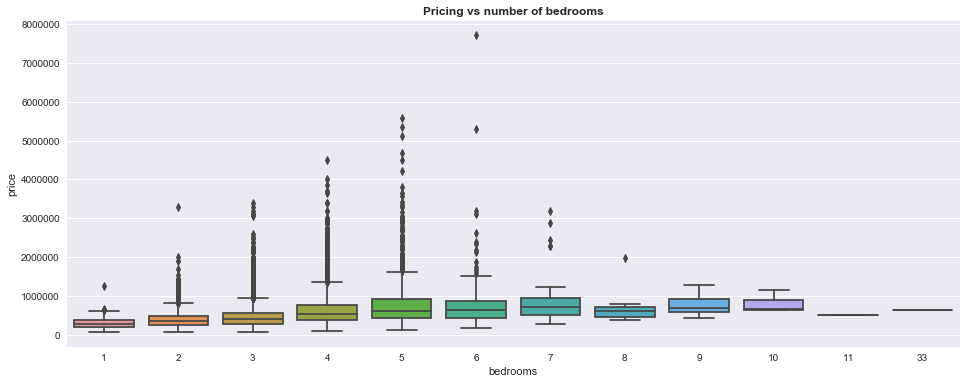

In [8]:
# Pricing vs number of bedrooms
plt.figure(figsize=(16, 6))
sns.boxplot(y='price', x='bedrooms', data=train)
plt.title('Pricing vs number of bedrooms', fontweight='bold')
plt.show()

Rooms with more bedrooms are priced relatively higher, but this trend saturates beyond 6 bedrooms. And the one with 33 bedrooms is probably a hotel or guest house of sorts. What will one family do with 33 beds?

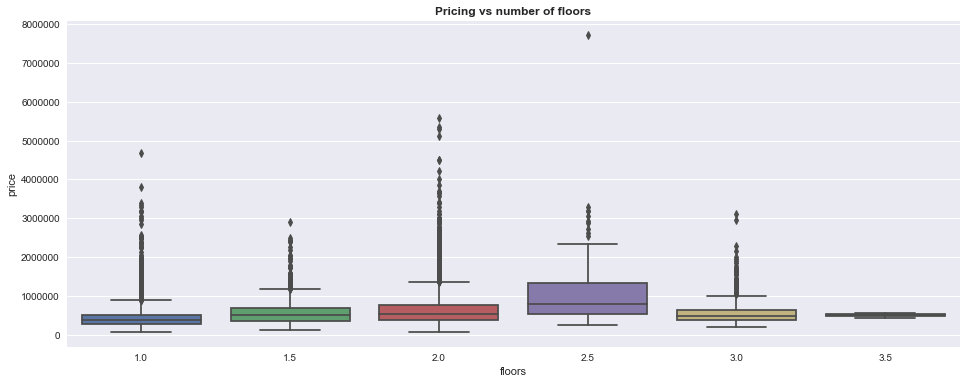

In [9]:
# Pricing vs number of floors
plt.figure(figsize=(16, 6))
sns.boxplot(y='price', x='floors', data=train)
plt.title('Pricing vs number of floors', fontweight='bold')
plt.show()


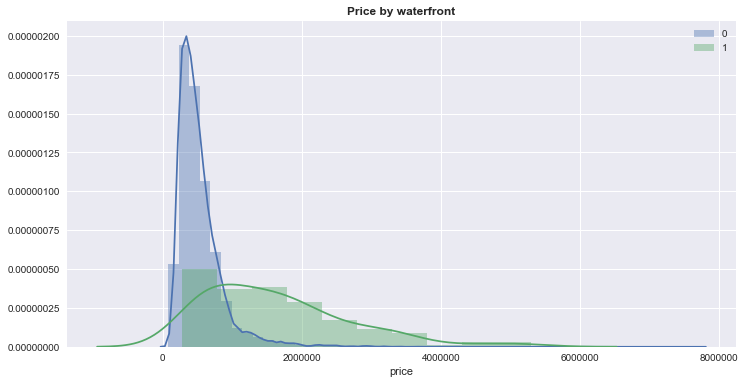

In [10]:
# Effect of waterfront on price
plt.figure(figsize=(12, 6))
for val in train['waterfront'].unique():
    sns.distplot(train[train['waterfront']==val]['price'], hist=True, kde=True, label=val)
plt.title('Price by waterfront', fontweight='bold')
plt.legend()
plt.show()

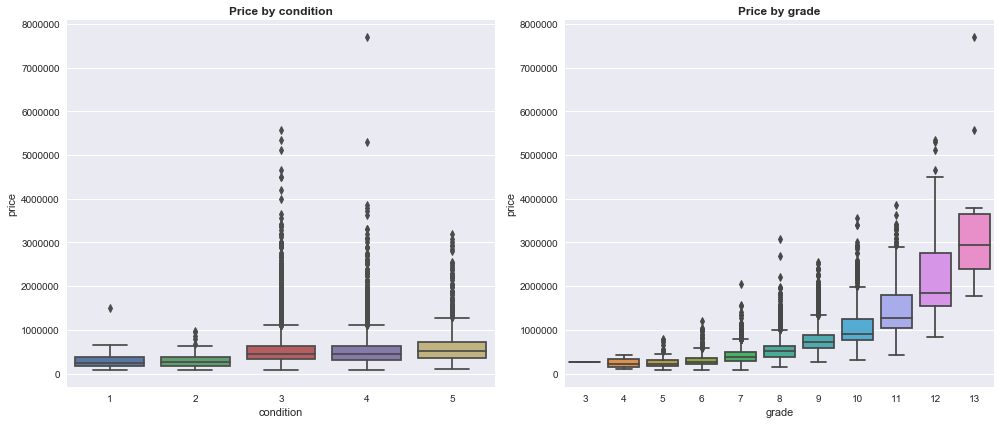

In [11]:
# Price by grade and condition
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.boxplot(y='price', x='condition', data=train)
ax1.set_title('Price by condition', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.boxplot(y='price', x='grade', data=train)
ax2.set_title('Price by grade', fontweight='bold')
plt.tight_layout()
plt.show()


It is clearly visible here that condition is a poor inidicator of price while grade is a really strong indicator of price.

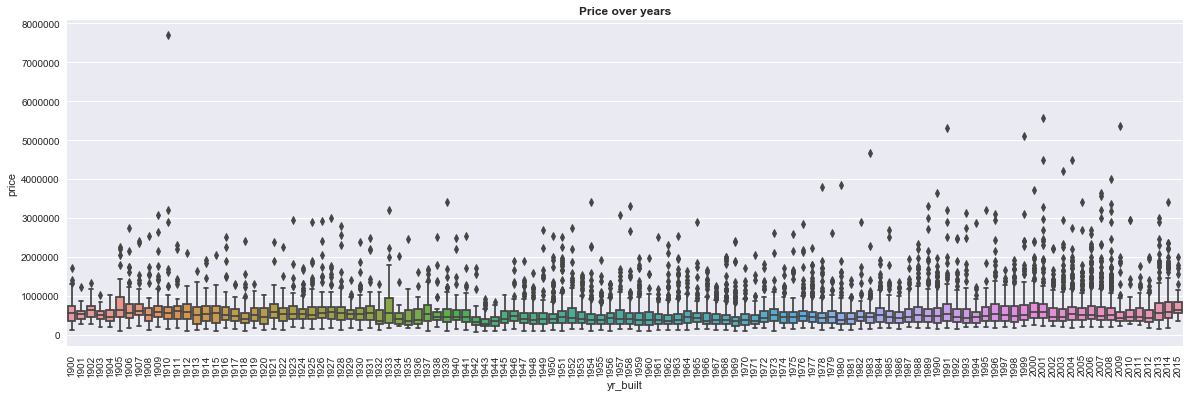

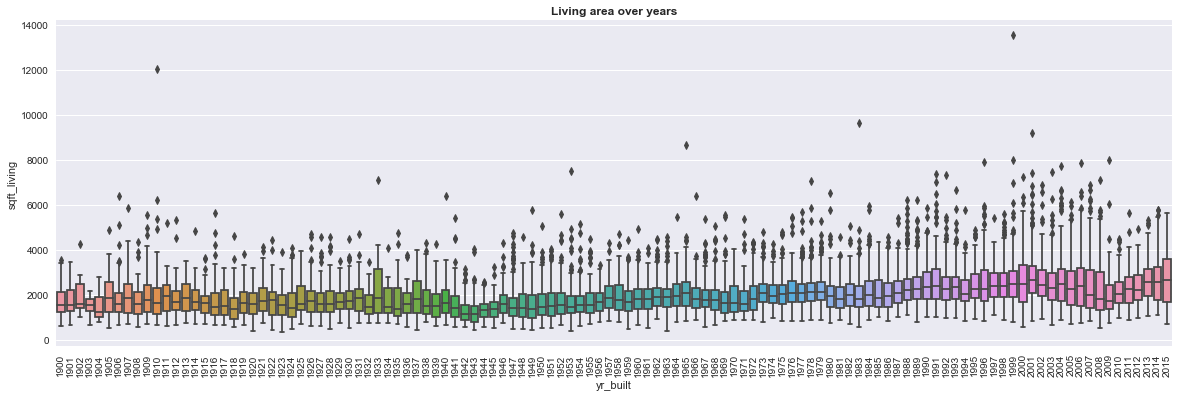

In [12]:
# Price variation along years
plt.figure(figsize=(20, 6))
sns.boxplot(y='price', x='yr_built', data=train)
plt.xticks(rotation=90)
plt.title('Price over years', fontweight='bold')
plt.show()

# Living area over years
plt.figure(figsize=(20, 6))
sns.boxplot(y='sqft_living', x='yr_built', data=train)
plt.xticks(rotation=90)
plt.title('Living area over years', fontweight='bold')
plt.show()


Living area and pricing for houses haven't changed remarkably with age, but are slightly higher for newer houses.

In [13]:
# Map distribution of prices
# Adapted from a Kaggle kernel I read sometime earlier
train_copy = train.copy()
train_copy['price_minus_mean'] = train_copy['price'] - train_copy['price'].mean()
lat_mean, long_mean = train['lat'].mean(), train['long'].mean()

def generateBaseMap(default_location=[lat_mean, long_mean], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
    
# Generate basemap and add prices heatmap
basemap = generateBaseMap()
HeatMap(data=train_copy[['lat', 'long', 'price_minus_mean']].groupby(['lat', 'long']).mean().reset_index().values.tolist(),
        radius=8, max_zoom=13, name='Price heatmap').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)

basemap

Turns out these locations are near the west coast of USA. The above heatmap displays locations where prices are above mean (more red, heigher above mean). Prices around Seattle, Bellevue and Redmond are above mean.

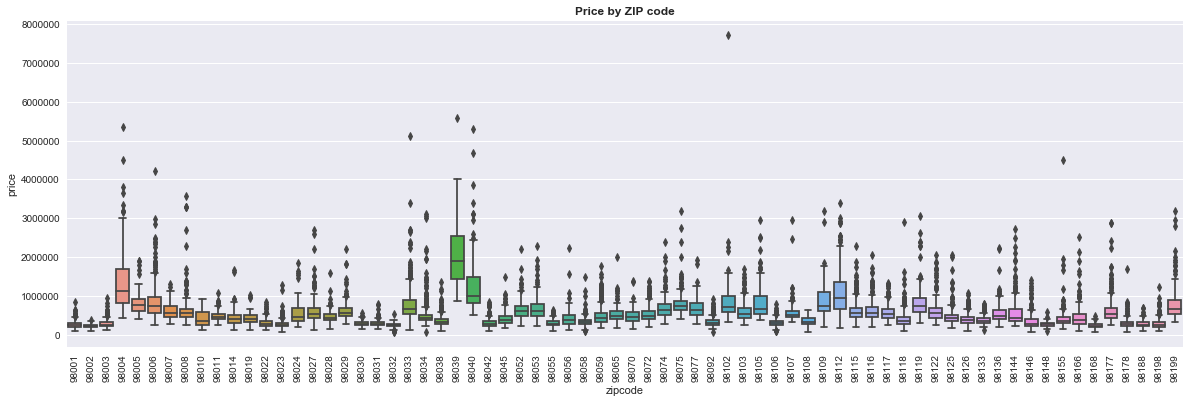

In [14]:
# Price distribution over zipcode
plt.figure(figsize=(20, 6))
sns.boxplot(x='zipcode', y='price', data=train_copy)
plt.xticks(rotation=90)
plt.title('Price by ZIP code', fontweight='bold')
plt.show()

Some zipcodes have higher pricing than others. Perhaps this data is captured by lat and long, but this feature acts as a concatenation of both.

### New Features
Here I'll add some new features and we'll see if it helps us predict house prices better.

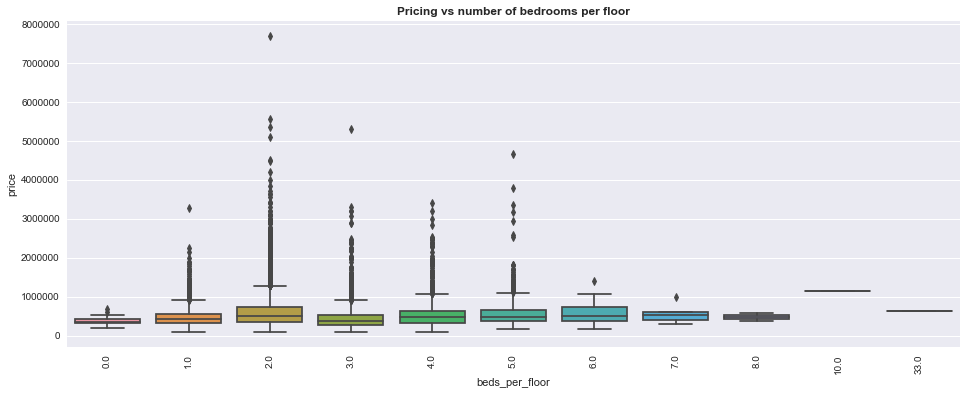

In [15]:
# Bedrooms per floor
train['beds_per_floor'] = np.round(train['bedrooms']/train['floors'])
plt.figure(figsize=(16, 6))
sns.boxplot(y='price', x='beds_per_floor', data=train)
plt.xticks(rotation=90)
plt.title('Pricing vs number of bedrooms per floor', fontweight='bold')
plt.show()

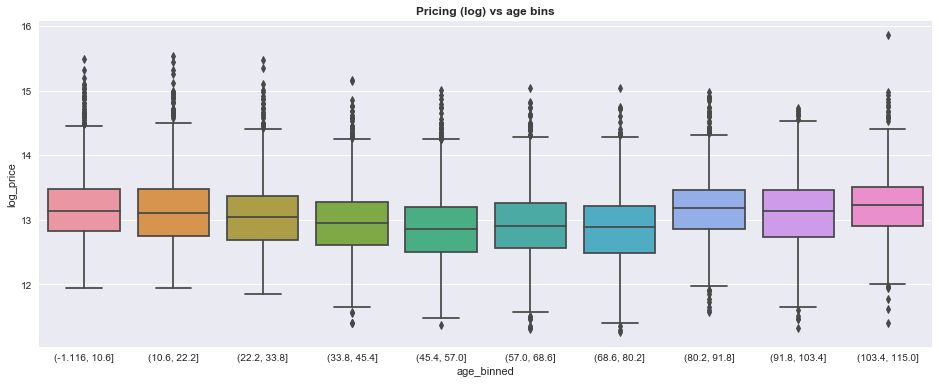

In [16]:
# Age of the house
train_copy['age'] = (train_copy['date'].dt.year - train_copy['yr_built']).astype('int')
train_copy['age_binned'] = pd.cut(train_copy['age'], 10)
train_copy['log_price'] = train_copy['price'].apply(np.log)
plt.figure(figsize=(16, 6))
sns.boxplot(y='log_price', x='age_binned', data=train_copy)
plt.title('Pricing (log) vs age bins', fontweight='bold')
plt.show()

Very new and very old houses are priced higher than those with in-between ages. Also the first bin reveals that there are cases where the year in which the buiilding is built is in the future of the current date (negative date). We cannot outright exclude these rows because there are rows with this behavior in test data as well. So we'll generate this feature, and hopefully the rows with negative values in train data will help the regressor predict for similar rows in test data.

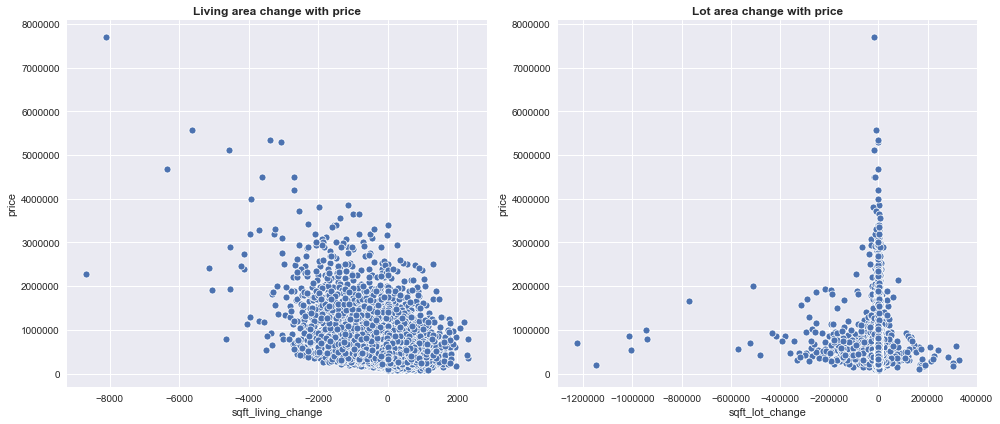

In [17]:
# Effect of change in living and lot area on price
train_copy['sqft_living_change'] = train_copy['sqft_living15'] - train_copy['sqft_living']
train_copy['sqft_lot_change'] = train_copy['sqft_lot15'] - train_copy['sqft_lot']

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.scatterplot(x='sqft_living_change', y='price', data=train_copy)
ax1.set_title('Living area change with price', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.scatterplot(x='sqft_lot_change', y='price', data=train_copy)
ax2.set_title('Lot area change with price', fontweight='bold')
plt.tight_layout()
plt.show()

It seems houses with reduction in living area have relatively higher prices. Maybe the deprecated area was used for development of other services which add more value to the house than simply having a lot of living space. Also houses with no change in lot area are priced higher than those whose lot areas changed.

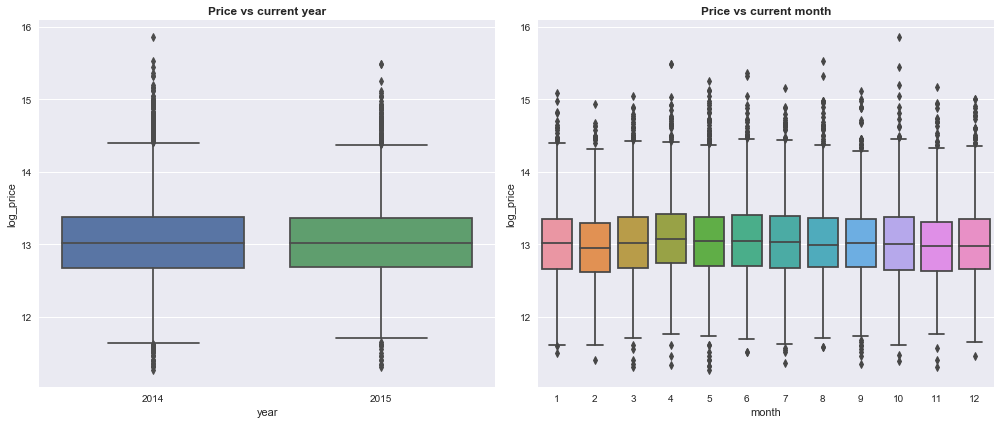

In [18]:
# Prices by year and month
train_copy['year'] = train_copy['date'].dt.year
train_copy['month'] = train_copy['date'].dt.month

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
sns.boxplot(x='year', y='log_price', data=train_copy)
ax1.set_title('Price vs current year', fontweight='bold')
ax2 = fig.add_subplot(122)
sns.boxplot(x='month', y='log_price', data=train_copy)
ax2.set_title('Price vs current month', fontweight='bold')
plt.tight_layout()
plt.show()

### About feature distributions
In this section I've commented on the distribution of some continuous features.

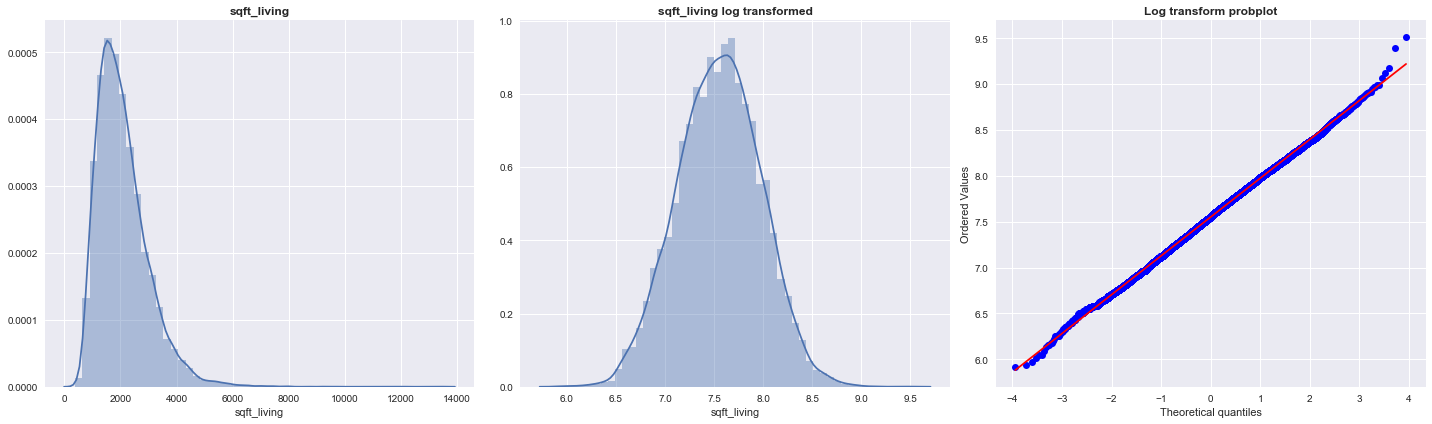

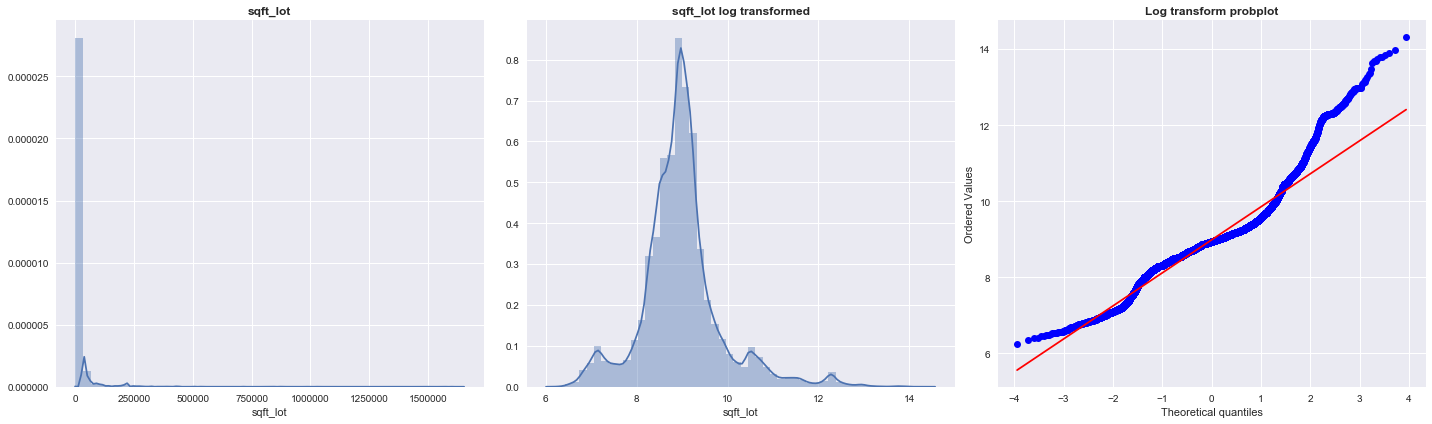

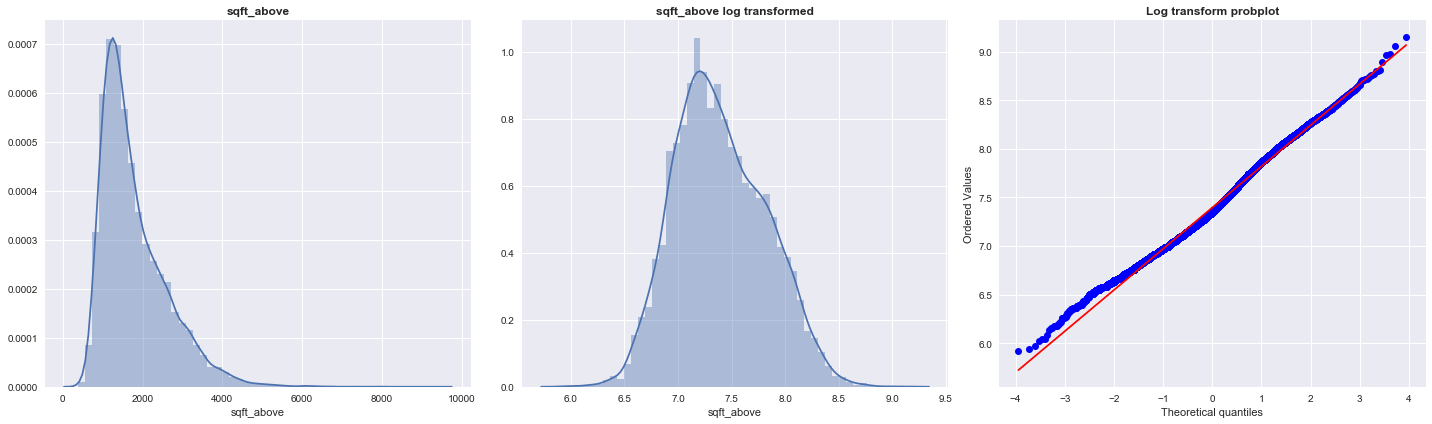

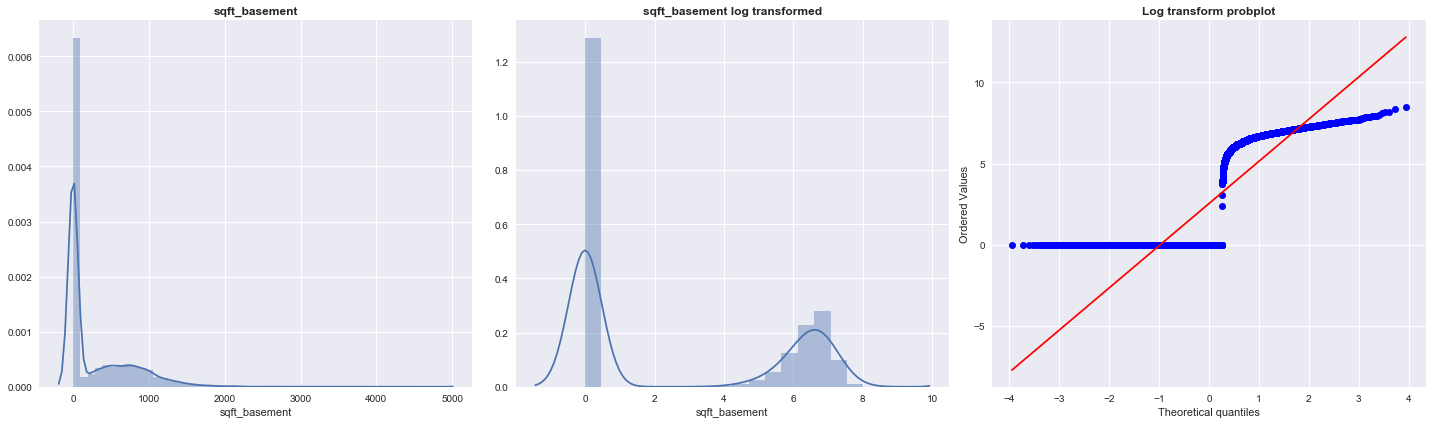

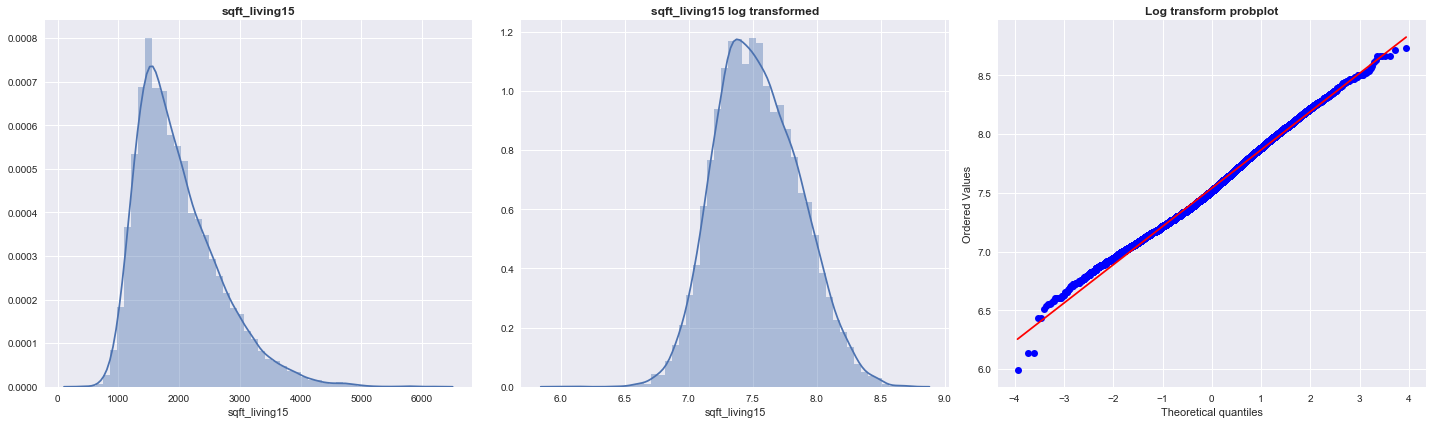

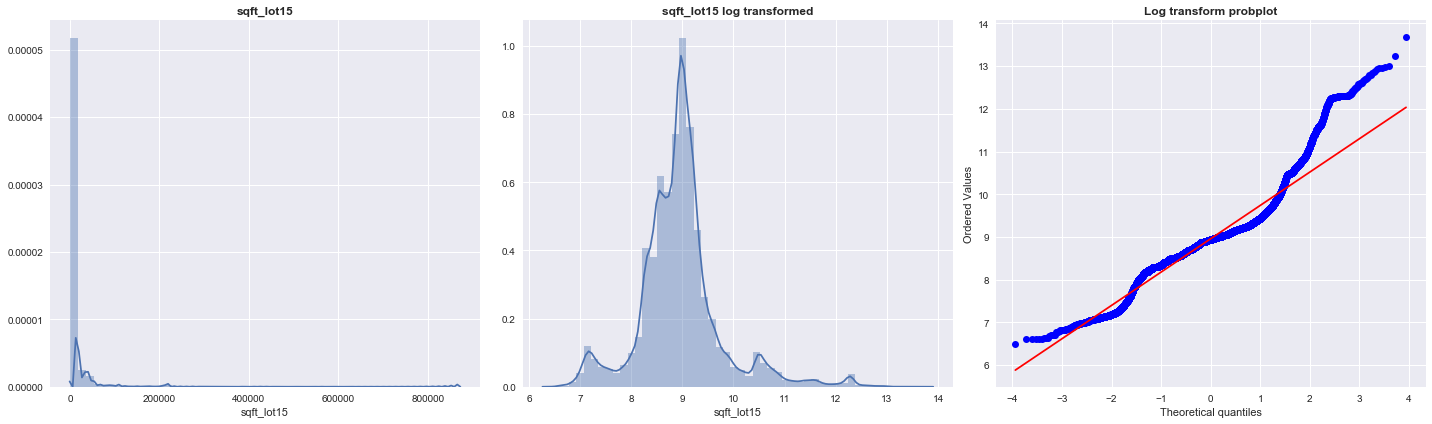

In [19]:
cont_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
             'sqft_living15', 'sqft_lot15']
for col in cont_cols:
    fig = plt.figure(figsize=(20, 6))
    ax1 = fig.add_subplot(131)
    sns.distplot(train[col], kde=True, hist=True)
    ax1.set_title(col, fontweight='bold')
    ax2 = fig.add_subplot(132)
    sns.distplot(train[col].apply(lambda x: np.log(x+1)), kde=True, hist=True)
    ax2.set_title(col + ' log transformed', fontweight='bold')
    ax3 = fig.add_subplot(133)
    probplot(train[col].apply(lambda x: np.log(x+1)), dist='norm', plot=plt)
    ax3.set_title('Log transform probplot', fontweight='bold')
    plt.tight_layout()
    plt.show()

Some models require than features be distributed normally; here is an attempt to normalize some continuous features. The probplots above reveal that most features come decently close to a normal disribution when log transformed, with the exception of sqft_basement. For that one, the disturbing factor is the enormous amount of zeros, or houses which (probably) do not have basements. For linear models, it would be best to convert this into a categorical feature: whether the house has a basement or not. We will use a gradient boosting machine here, so I have kept it as is. Since tree based models aren't really affected by feature distributions, I haven't transformed any other feature either to preserve their natural distribution (prevent variance shift or scaling).

### Adding final features
After all the analysis above, the features in this section have been added. I understand that not many good features were discovered above, and hopefully the model will do well with these features and the ones that are chosen out of the original set of features. Here is the list of features added.

1.Age of the house
2.Change in living area between 2015 and building year
3.Change in lot area between 2015 and building year
4.Month of recording
5.Year of recording
5.KNN features: If I were to go and purchase a house at some location, I would ask for prices of houses around to get an estimate of what this house might cost. These features attempt to capture that information. A KNN regressor is trained on training data prices using only lat and long as features (loosely utitlizing the heatmap generously shared by AC heads). This is then used to predict possible prices for train data itself as well as test data.

In [20]:
def add_features(df):
    df['age'] = (df['date'].dt.year - df['yr_built']).astype('int')
    df['sqft_living_delta'] = df['sqft_living15'] - df['sqft_living']
    df['sqft_lot_delta'] = df['sqft_lot15'] - df['sqft_lot']
    df['date_month'] = df['date'].dt.month
    df['date_year'] = df['date'].dt.year
    return df

def add_knn_estimate(df, df_train):
    X_train, y_train = df_train[['lat', 'long']], df_train['price']
    X = df[['lat', 'long']]
    for k in [20, 50, 70, 100]:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        df['local'+str(k)+'_price_estimate'] = knn.predict(X)
    return df

train = add_features(train)
test = add_features(test)
train = add_knn_estimate(train, train)
test = add_knn_estimate(test, train)

### Models
In this final section, I will show the model I built to generate my predictions. I haven't shown any hyperparameter tuning details as all of them were manually tuned. As to why XGBoost was chosen: gradient boosting machines are known to perform well on structured data (not always, but in general) especially when features have widely varying scales and categorical features have too many categories (making one-hot encoding a bad option). Since our data loosely fits into this picture, I decided to go ahead with it.

In [22]:
# Some columns will not be used for prediction
# Dropping them here
drop_cols = ['id', 'date']
test_ids = test['id'].values   # Preserving for final submission
train_data = train.drop(drop_cols, axis=1)
test_data = test.drop(drop_cols, axis=1)

In [23]:
# XGBoost does not have RMSLE internally defined
# Defined it here so I can use it to monitor progress with Python API
def RMSLE(preds, dmatrix):
    labels = dmatrix.get_label()
    diffs = np.log(preds + 1) - np.log(labels + 1)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('RMSLE', np.sqrt(avg))

In [24]:
# KFold cross validation
# XGBoost with configuration that gave me best performance
# I didn't use random state earlier so I'm not sure if it'll ...
# ... converge to the same local minimum
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.03,
    'max_depth': 11,
    'reg_lambda': 100.0,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'random_state': 42
}

X, y = train_data.drop('price', axis=1), train_data['price']
kf = KFold(n_splits=3)
val_scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    d_train = xgb.DMatrix(data=X_train, label=y_train)
    d_val = xgb.DMatrix(data=X_val, label=y_val)
    model = xgb.train(
        xgb_params, d_train,
        evals = [(d_train, 'Train'), (d_val, 'Val')],
        feval = RMSLE,
        maximize = False,
        num_boost_round = 100000,
        verbose_eval = 100,
        early_stopping_rounds = 500
    )
    val_preds = model.predict(d_val)
    score = mean_squared_log_error(y_val, val_preds)**0.5
    val_scores.append(score)
    print('\n')
    
print("Validation scores: {}".format(val_scores))
print("Average validation RMSLE: {:.5f}".format(np.mean(val_scores)))

[0]	Train-rmse:639610.68750	Val-rmse:632149.43750	Train-RMSLE:3.54578	Val-RMSLE:3.53570
Multiple eval metrics have been passed: 'Val-RMSLE' will be used for early stopping.

Will train until Val-RMSLE hasn't improved in 500 rounds.
[100]	Train-rmse:178603.96875	Val-rmse:194947.82812	Train-RMSLE:0.18346	Val-RMSLE:0.19806
[200]	Train-rmse:133289.56250	Val-rmse:158128.21875	Train-RMSLE:0.14905	Val-RMSLE:0.17403
[300]	Train-rmse:114254.09375	Val-rmse:143283.96875	Train-RMSLE:0.13749	Val-RMSLE:0.16779
[400]	Train-rmse:102279.72656	Val-rmse:134756.65625	Train-RMSLE:0.13028	Val-RMSLE:0.16507
[500]	Train-rmse:93620.79688	Val-rmse:129174.03125	Train-RMSLE:0.12462	Val-RMSLE:0.16337
[600]	Train-rmse:86848.31250	Val-rmse:125486.51562	Train-RMSLE:0.11950	Val-RMSLE:0.16224
[700]	Train-rmse:81362.37500	Val-rmse:122713.25000	Train-RMSLE:0.11509	Val-RMSLE:0.16161
[800]	Train-rmse:76881.14844	Val-rmse:120857.75781	Train-RMSLE:0.11106	Val-RMSLE:0.16113
[900]	Train-rmse:72841.30469	Val-rmse:119433.28906	T

In [25]:
# Generating prediction file
d_train = xgb.DMatrix(data=X, label=y)
d_test = xgb.DMatrix(data=test_data)

model = xgb.train(
        xgb_params, d_train,
        feval = RMSLE,
        maximize = False,
        num_boost_round = 1200,
    )

test_preds = model.predict(d_test)
sub_df = pd.DataFrame(np.vstack((test_ids, test_preds)).T, columns=['id', 'price'])
sub_df['id'] = sub_df['id'].astype('int')
sub_df.to_csv('.././data/submission_XGB.csv', index=False)

ValueError: feature_names mismatch: ['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'beds_per_floor', 'age', 'sqft_living_delta', 'sqft_lot_delta', 'date_month', 'date_year', 'local20_price_estimate', 'local50_price_estimate', 'local70_price_estimate', 'local100_price_estimate'] ['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 'sqft_living_delta', 'sqft_lot_delta', 'date_month', 'date_year', 'local20_price_estimate', 'local50_price_estimate', 'local70_price_estimate', 'local100_price_estimate']
expected beds_per_floor in input data

### Feature Importances
Now that XGBoost has been trained, let's see how much each feature was useful.

In [ ]:
imp_dict = model.get_score(importance_type='gain')
imp_dict = {k: v/max(list(imp_dict.values())) for (k, v) in imp_dict.items()}
cols = np.array(list(imp_dict.keys()))
imps = np.array(list(imp_dict.values()))
imp_df = pd.DataFrame(np.vstack((cols, imps)).T, columns=['column', 'importance_ratio'])
imp_df['importance_ratio'] = imp_df['importance_ratio'].astype('float')

# Plot
imp_df.set_index('column')['importance_ratio'].sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('XGBoost Feature Importance by Gain', fontweight='bold')
plt.show()

Two of the features we created, KNN estimates at 20 and 50 neighbors, have been helpful in prediction. So decent feature engineering I guess. :)

### LightGBM with categorical features
For experimental purposes only.

In [26]:
cat_fs = ['date_month', 'date_year', 'zipcode']

# LightGBM
lgb_params = {
    'objective': 'regression',
    'learning_rate': 0.03,
    'max_depth': 11,
    'reg_lambda': 100.0,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'random_state': 42,
}

X, y = train_data.drop('price', axis=1), train_data['price']
kf = KFold(n_splits=3)
val_scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    d_train = lgb.Dataset(data=X_train, label=y_train, categorical_feature=cat_fs)
    d_val = lgb.Dataset(data=X_val, label=y_val, categorical_feature=cat_fs)
    model = lgb.train(
        lgb_params, d_train,
        valid_sets = [d_train, d_val],
        num_boost_round = 100000,
        verbose_eval = 100,
        early_stopping_rounds = 500
    )
    val_preds = model.predict(X_val)
    score = mean_squared_log_error(y_val, val_preds)**0.5
    val_scores.append(score)
    print('\n')
    
print("Validation scores: {}".format(val_scores))
print("Average validation RMSLE: {:.5f}".format(np.mean(val_scores)))

C:\Users\CG-DTE\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[100]	training's l2: 2.22806e+10	valid_1's l2: 2.85452e+10
[200]	training's l2: 1.39217e+10	valid_1's l2: 1.96868e+10
[300]	training's l2: 1.09543e+10	valid_1's l2: 1.65799e+10
[400]	training's l2: 9.29689e+09	valid_1's l2: 1.51961e+10
[500]	training's l2: 8.19908e+09	valid_1's l2: 1.44019e+10
[600]	training's l2: 7.42503e+09	valid_1's l2: 1.39249e+10
[700]	training's l2: 6.81629e+09	valid_1's l2: 1.35951e+10
[800]	training's l2: 6.30518e+09	valid_1's l2: 1.33799e+10
[900]	training's l2: 5.88218e+09	valid_1's l2: 1.318e+10
[1000]	training's l2: 5.48969e+09	valid_1's l2: 1.30611e+10
[1100]	training's l2: 5.14869e+09	valid_1's l2: 1.29758e+10
[1200]	training's l2: 4.8547e+09	valid_1's l2: 1.28925e+10
[1300]	training's l2: 4.58932e+09	valid_1's l2: 1.2818e+10
[1400]	training's l2: 4.3454e+09	valid_1's l2: 1.27589e+10
[1500]	training's l2: 4.13327e+09	valid_1's l2: 1.26899e+10
[1600]	training's l2: 3.92524e+09	valid_1's l2: 1.26

C:\Users\CG-DTE\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's l2: 2.21739e+10	valid_1's l2: 2.7849e+10
[200]	training's l2: 1.33355e+10	valid_1's l2: 1.96535e+10
[300]	training's l2: 1.02591e+10	valid_1's l2: 1.69717e+10
[400]	training's l2: 8.59308e+09	valid_1's l2: 1.55872e+10
[500]	training's l2: 7.55696e+09	valid_1's l2: 1.4845e+10
[600]	training's l2: 6.75253e+09	valid_1's l2: 1.44563e+10
[700]	training's l2: 6.0815e+09	valid_1's l2: 1.42767e+10
[800]	training's l2: 5.51663e+09	valid_1's l2: 1.41715e+10
[900]	training's l2: 5.05723e+09	valid_1's l2: 1.40803e+10
[1000]	training's l2: 4.66741e+09	valid_1's l2: 1.40004e+10
[1100]	training's l2: 4.34009e+09	valid_1's l2: 1.39175e+10
[1200]	training's l2: 4.0516e+09	valid_1's l2: 1.3891e+10
[1300]	training's l2: 3.79833e+09	valid_1's l2: 1.38465e+10
[1400]	training's l2: 3.57175e+09	valid_1's l2: 1.38321e+10
[1500]	training's l2: 3.36961e+09	valid_1's l2: 1.38353e+10
[1600]	training's l2: 3.19236e+09	valid_1's l2: 1.38382e+10
[1700]	training's l2: 3.02505e+09	valid_1's l2: 1.3825

C:\Users\CG-DTE\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's l2: 2.46462e+10	valid_1's l2: 2.18118e+10
[200]	training's l2: 1.45997e+10	valid_1's l2: 1.51002e+10
[300]	training's l2: 1.10985e+10	valid_1's l2: 1.37163e+10
[400]	training's l2: 9.32807e+09	valid_1's l2: 1.31703e+10
[500]	training's l2: 8.17084e+09	valid_1's l2: 1.29489e+10
[600]	training's l2: 7.31815e+09	valid_1's l2: 1.28678e+10
[700]	training's l2: 6.64398e+09	valid_1's l2: 1.27989e+10
[800]	training's l2: 6.09652e+09	valid_1's l2: 1.27778e+10
[900]	training's l2: 5.64298e+09	valid_1's l2: 1.27807e+10
[1000]	training's l2: 5.24746e+09	valid_1's l2: 1.27717e+10
[1100]	training's l2: 4.9129e+09	valid_1's l2: 1.27638e+10
[1200]	training's l2: 4.60522e+09	valid_1's l2: 1.2786e+10
[1300]	training's l2: 4.31982e+09	valid_1's l2: 1.27866e+10
[1400]	training's l2: 4.07827e+09	valid_1's l2: 1.2778e+10
[1500]	training's l2: 3.86414e+09	valid_1's l2: 1.2791e+10
[1600]	training's l2: 3.68029e+09	valid_1's l2: 1.28065e+10
Early stopping, best iteration is:
[1130]	training's 